In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
session = tf.Session(config=config)

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)

## Data Generation

In [323]:
def generate_samples(size=1, variance=0.03,randomness=True):
    """
    Generates samples as described in the paper
    """
    alpha = 4
    beta = 13
    if  randomness:
        # Heteroscedastic noise
        w = np.random.normal(0, variance, size=size)
        x1 = np.linspace(0, 0.6, 0.6 * size)
        x2 = np.linspace(0.8, 1.0, 0.4 * size)
        
        #x1 = np.random.uniform(low=0, high=0.6, size=size)
        #x2 = np.random.uniform(low=0.8, high=1.0, size=size)
    
        x = np.append(x1, x2)
    else:
        w = np.zeros(size*2)
        x = np.linspace(0, 1, size * 2)
    
    y = x + np.sin(alpha * (x + w)) + np.sin(beta * (x + w)) + w
    
    return x, y

def generate_samples_heteroscedastic(size=1, variance=0.03,randomness=True):
    alpha = 4
    beta = 13
    if  randomness:
        # Heteroscedastic noise
        w1 = np.random.normal(0, variance, size=int(0.6*size))
        x1 = np.linspace(0, 0.6, 0.6 * size)
        
        w2 = np.random.normal(0, variance*0, size=int(0.4*size))
        x2 = np.linspace(0.8, 1.0, 0.4 * size)
    
        x = np.append(x1, x2)
        w = np.append(w1, w2)
    else:
        w = np.zeros(size*2)
        x = np.linspace(0, 1, size * 2)
    
    y = x + np.sin(alpha * (x + w)) + np.sin(beta * (x + w)) + w
    
    return x, y, w

def generate_nonlinear():
    """ Example from Risk vs Uncertainty paper"""
    x = np.array([-1, -1, 0.01, 0.01, 1, 1])
    y = np.array([-1, 1, -1, 1, -1, 1])
    
    return x, y


def generate_linear():
    x = np.array(range(1000000))
    y = np.array(range(1000000))
    return x, y

def generate_sin():
    x = np.array(np.arange(-2, 2, 0.0001))
    y = np.sin(x)
    
    return x, y

# Model building

### Fully-Connected with Dropout

In [1]:
n_passes = 30
dropout_rate = 0.5

def fcn_dropout_network(features, labels, mode):
    with tf.device("/gpu:0"):
        training = True
        
        input_layer = tf.feature_column.input_layer(features, tf.feature_column.numeric_column("x"))

        fc1 = tf.layers.dense(inputs=input_layer, units=50, activation=tf.nn.relu)
        fc1 = tf.layers.dropout(fc1, dropout_rate, training=True)
        
        fc2 = tf.layers.dense(inputs=fc1, units=50, activation=tf.nn.relu)
        fc2 = tf.layers.dropout(fc2, dropout_rate, training=True)

        output_layer = tf.layers.dense(inputs=fc2, units=1)
        predictions = tf.reshape(output_layer, [-1])
        
        if mode == tf.estimator.ModeKeys.PREDICT:
            return tf.estimator.EstimatorSpec(
                mode=mode, predictions=predictions)

        average_loss =  tf.losses.mean_squared_error(labels, predictions)
        average_loss = tf.identity(average_loss, name="average_loss")

        batch_size = tf.shape(labels)[0]
        total_loss = tf.to_float(batch_size) * average_loss

        if mode == tf.estimator.ModeKeys.TRAIN:
            optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
            train_op = optimizer.minimize(
                loss=total_loss, global_step=tf.train.get_global_step())

            return tf.estimator.EstimatorSpec(
                mode=mode, loss=average_loss, train_op=train_op)


model = tf.estimator.Estimator(model_fn=fcn_dropout_network)

#x, y = generate_samples(50)

x, y = generate_nonlinear()

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x}, y=y, shuffle=True, num_epochs=10**6)
# steps total
model.train(input_fn=train_input_fn, steps=10000)

#pred_x = np.arange(-0.3, 1.2, 0.01)
pred_x = np.arange(-3, 3, 0.01)
pred_x = np.array([[e] * n_passes for e in pred_x]).flatten()

predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": pred_x}, shuffle=False)
predictions = model.predict(input_fn=predict_input_fn)
pred_y = np.array([p for p in predictions])

# Recalculate Means and Variances from extended pred_x and pred_y
pred_x = pred_x.reshape(-1, n_passes).mean(axis=1)
pred_y_old = pred_y
pred_y = pred_y.reshape(-1, n_passes).mean(axis=1)
var = pred_y_old.reshape(-1, n_passes).std(axis=1)

#f, ax = plt.subplots(1, )
plt.figure(figsize=(20,10))
plt.scatter(x, y, label="training samples")
plt.scatter(pred_x, pred_y, color="red", label="prediction")
#plt.plot(x_true, y_true, color="black", label="true")
plt.fill_between(pred_x, pred_y - var, pred_y + var, alpha=0.5)
plt.fill_between(pred_x, 0, var, alpha=0.5, label="variance")
plt.legend()

NameError: name 'tf' is not defined

### Fully-Connected with Bootstrap

Implementation can either be done with $K$ separated networks or a shared network with $K$ heads. For each sample there is a $K$ Bit vector $m_i$ denoting whether head $k$ is trained with this sample. $m_i$ is drawn from the masking distribution $M$. It can be Bernoulli(0.5), Poisson 


In [87]:
from scipy.stats import bernoulli
import numpy.ma as ma

#n_samples = 50
#x, y = generate_samples(n_samples)

def evaluate_bootstrap(x, y, pred_range, n_heads=5, training_epochs=10000, plotting=True):
    """
    
    Keyword arguments:
    x -- samples x-coordinates
    y -- samples y-coordinates
    pred_range -- range for predictions, needs special shape
    n_head -- number of heads
    plotting -- indicate if output is plotted
    """

    assert len(x) == len(y)

    #assert len(x) == n_samples
    #assert len(y) == n_samples

    x = x.astype(np.float32)
    y = y.astype(np.float32)
    #n_heads = 10

    rv = bernoulli(0.5)
    # For every data point, associated heads
    # mask = rv.rvs(size=(n_samples, K)) 

    # For every mask the associated data points
    mask = rv.rvs(size=(n_heads, len(x)))

    # TODO add initializer
    x_data = tf.placeholder(tf.float32, [None, 1])
    y_data = tf.placeholder(tf.float32, [None, 1])

    def bootstrap_network(x, n_heads):
        with tf.device("/gpu:0"):

            #x = tf.reshape(x, [-1, 1])
            fc1 = tf.layers.dense(inputs=x, units=50, activation=tf.nn.relu)
            # Place second layer in shared network 
            #fc2 = tf.layers.dense(inputs=fc1, units=20, activation=tf.nn.relu)

            heads = []
            for i in range(n_heads):
                fc2 = tf.layers.dense(inputs=fc1, units=50, activation=tf.nn.relu)
                heads.append(tf.layers.dense(inputs=fc2, units=1))

            return heads

    heads = bootstrap_network(x_data, n_heads)

    learning_rate = 0.01
    #training_epochs = 10000
    display_step = 2000

    # optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate)

    loss_per_head = []
    train_per_head = []
    for head in heads:
        loss = tf.losses.mean_squared_error(y_data, head)
        #loss = tf.reduce_mean(tf.square(head - y_data))
        loss_per_head.append(loss)
        train_per_head.append(optimizer.minimize(loss))

    init = tf.global_variables_initializer()                                  
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    sess.run(init)

    for epoch in range(training_epochs):

        for i, t in enumerate(train_per_head):
            masked_x = ma.masked_array(x, mask[i]).compressed().reshape([-1, 1])
            masked_y = ma.masked_array(y, mask[i]).compressed().reshape([-1, 1]) 
            sess.run(t, feed_dict={x_data: masked_x, y_data: masked_y})

        if (epoch % display_step == 0):
            print("Epoch {}".format(epoch))
            for i, loss in enumerate(loss_per_head):
                curLoss = sess.run(loss, feed_dict={x_data: x.reshape([-1, 1]),
                                                    y_data: y.reshape([-1, 1])})
                print("Head {}: Loss {}".format(i, curLoss))
            print("================")

    print("Training done")
    
    if plotting == True:
        f, axs = plt.subplots(2, 1, sharey=True, figsize=(20,20))
        
        # TODO: Check shape
        pred_x = pred_range.reshape([-1, 1])
        #pred_x = np.arange(-3, 3.0, 0.01).reshape([-1, 1])
        #pred_x = np.linspace(-0.2, 1.2, 100).reshape([-1, 1])
        pred_ys = []
        plt.figure(figsize=(20,10))
        for i, head in enumerate(heads):
            pred_y = sess.run(head, feed_dict={x_data: pred_x})
            pred_ys.append(pred_y)
            axs[0].plot(pred_x, pred_y, label="Head " + str(i))
        axs[0].scatter(x, y, label="training samples")

        y_squeezed = np.squeeze(pred_ys, axis=2).transpose()
        y_mean = np.mean(y_squeezed, axis=1)
        y_var = np.std(y_squeezed, axis=1)
        axs[0].legend()
        axs[0].fill_between(np.squeeze(pred_x, axis=1), y_mean - y_var, y_mean + y_var, alpha=0.3)
        
        lower = axs[0].get_ylim()[0]
        axs[0].fill_between(np.squeeze(pred_x, axis=1), lower, lower + y_var, alpha=0.1)

        _ = axs[0].set_title("Different head approximations and their Standard Deviation")
        
        #axs[1].fill_between(np.squeeze(pred_x, axis=1), 0, y_var, alpha=0.5)

        axs[1].scatter(x, y)
        axs[1].plot(pred_x, y_mean, linewidth=1, alpha=1)
        axs[1].fill_between(np.squeeze(pred_x, axis=1), y_mean - y_var, y_mean + y_var, alpha=0.1, color="blue")
        _ = axs[1].set_title("Mean and Standard Deviation")


Epoch 0
Head 0: Loss 1.00296068192
Head 1: Loss 1.03328800201
Head 2: Loss 1.0793864727
Head 3: Loss 1.05469048023
Head 4: Loss 1.0037842989
Epoch 2000
Head 0: Loss 1.00458395481
Head 1: Loss 1.40892505646
Head 2: Loss 2.93875813484
Head 3: Loss 1.66723501682
Head 4: Loss 1.66663706303
Epoch 4000
Head 0: Loss 1.00421857834
Head 1: Loss 1.41326797009
Head 2: Loss 2.54089140892
Head 3: Loss 1.66765975952
Head 4: Loss 1.66646182537
Epoch 6000
Head 0: Loss 1.0052036047
Head 1: Loss 1.50690233707
Head 2: Loss 2.12044405937
Head 3: Loss 1.66530573368
Head 4: Loss 1.66582000256
Training done


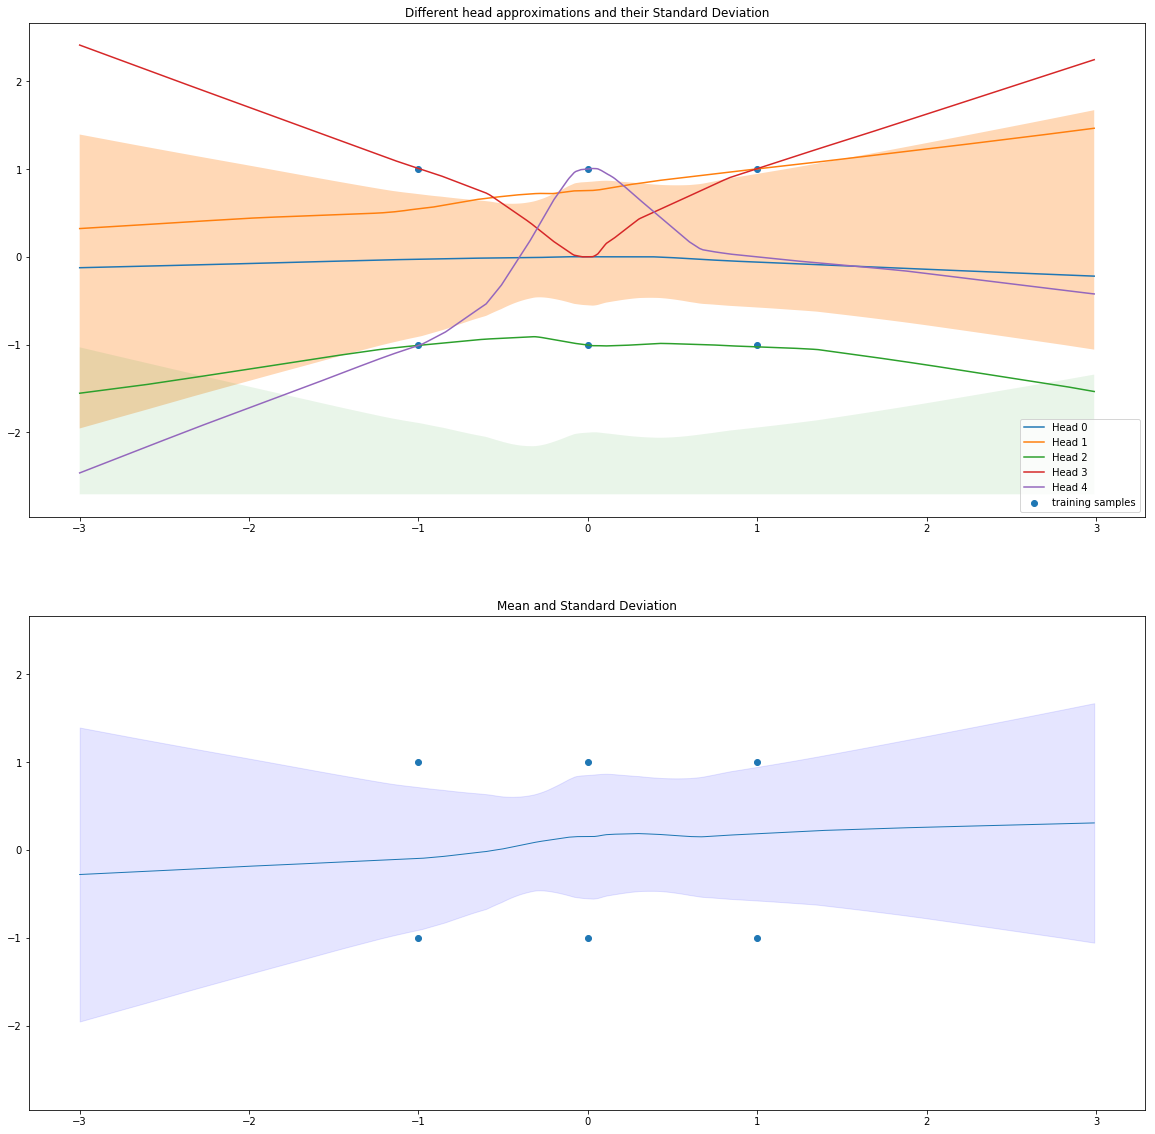

In [90]:
x, y = generate_nonlinear()
pred_range =np.arange(-3, 3.0, 0.01) # evaluation range
evaluate_bootstrap(x, y, pred_range, 5, training_epochs=8000)

/disk/users/hutmache/.Envs/ros_e2e/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/disk/users/hutmache/.Envs/ros_e2e/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


Epoch 0
Head 0: Loss 0.989405870438
Head 1: Loss 1.01352262497
Head 2: Loss 1.10206615925
Head 3: Loss 1.06674528122
Head 4: Loss 1.02920687199
Epoch 2000
Head 0: Loss 0.0775962993503
Head 1: Loss 0.0412382036448
Head 2: Loss 0.0727954953909
Head 3: Loss 0.0499521270394
Head 4: Loss 0.0539410784841
Epoch 4000
Head 0: Loss 0.0701469630003
Head 1: Loss 0.0505595952272
Head 2: Loss 0.0643258318305
Head 3: Loss 0.047948975116
Head 4: Loss 0.0482284538448
Epoch 6000
Head 0: Loss 0.0802385509014
Head 1: Loss 0.0549997538328
Head 2: Loss 0.0678777247667
Head 3: Loss 0.0510334521532
Head 4: Loss 0.0616628825665
Training done


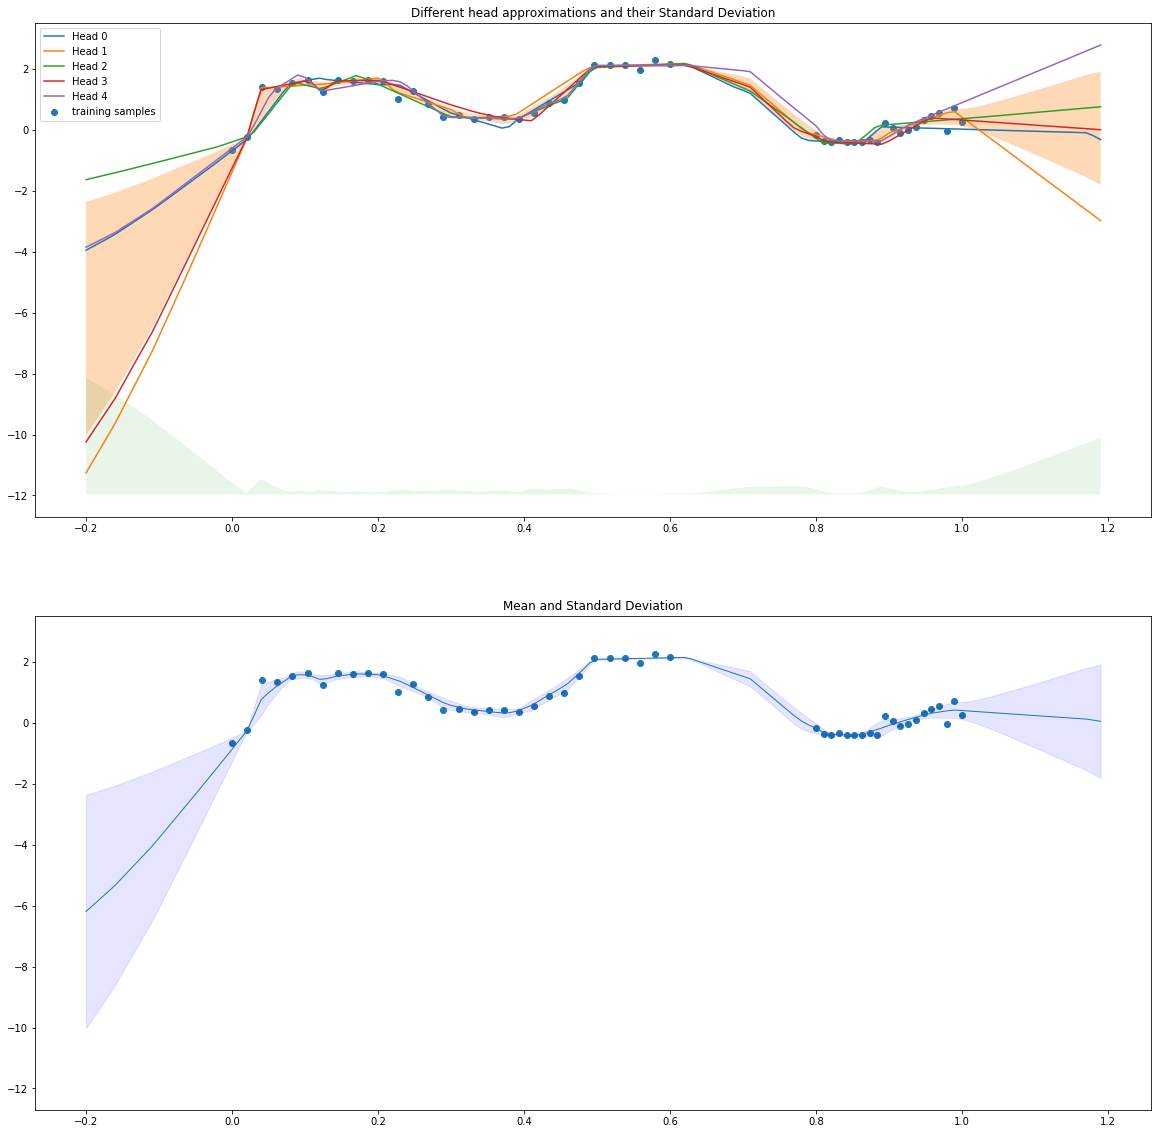

In [89]:
n_samples = 50
x, y = generate_samples(n_samples)
pred_range =np.arange(-0.2, 1.2, 0.01) # evaluation range
evaluate_bootstrap(x, y, pred_range, 5, training_epochs=8000)

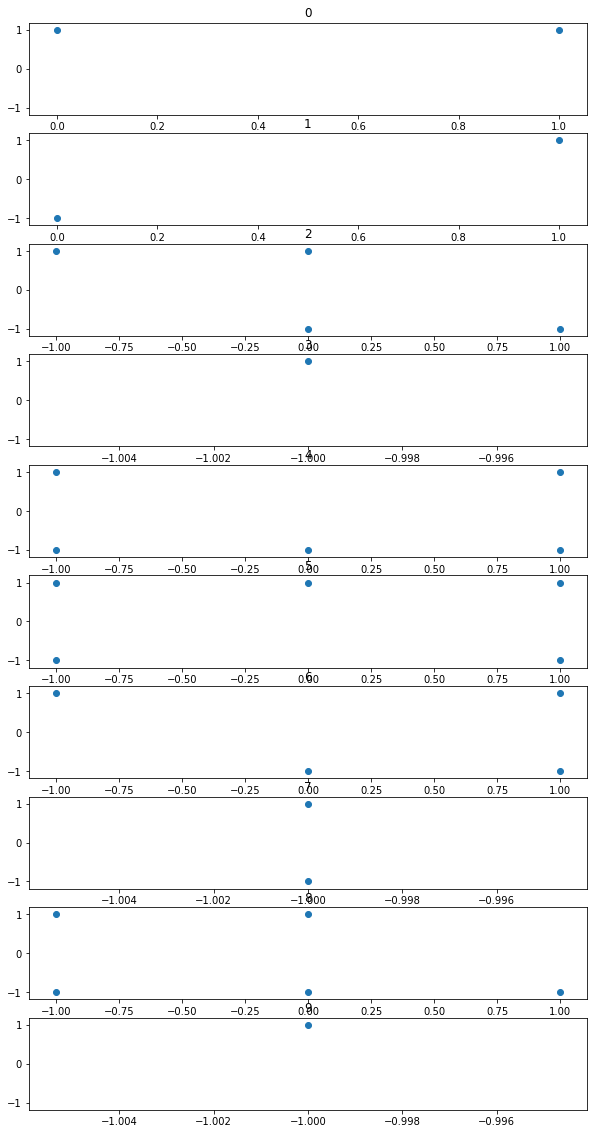

In [54]:
# Plot the samples for the individual heads
f, axs = plt.subplots(n_heads, 1, sharey=True, figsize=(10,20))
for i in range(n_heads):
    ax = axs[i]
    masked_x = ma.masked_array(x, mask[i]).compressed().reshape([-1, 1])
    masked_y = ma.masked_array(y, mask[i]).compressed().reshape([-1, 1])
    ax.set_title(str(i))
    ax.scatter(masked_x, masked_y, label=str(i))

### Combining aleatoric and epistemic uncertainty

- Learn to output $\sigma$
- Define new loss function

/disk/users/hutmache/.Envs/ros_e2e/lib/python2.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/disk/users/hutmache/.Envs/ros_e2e/lib/python2.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


Epoch 0
Loss: [  2.07166478e-01   6.73576966e-02   2.80653546e-03   4.41391647e-01
   8.50896657e-01   5.33746421e-01   1.19857883e+00   1.36883818e-02
   9.09053028e-01   1.33329630e+00   1.29916036e+00   1.05618703e+00
   1.36655092e+00   1.37045729e+00   1.39264965e+00   1.08125389e+00
   1.36773419e+00   1.42457902e+00   1.22959435e+00   8.96091580e-01
   1.25807786e+00   1.04795420e+00   5.52114129e-01   3.97085309e-01
   1.04452014e+00   2.62191504e-01   2.27865681e-01   3.52064401e-01
   7.01718569e-01   1.97946802e-01   2.90593684e-01   1.15437903e-01
   5.42759076e-02   1.17404819e-01   9.64115039e-02   1.15319148e-01
   7.79482871e-02   1.50113493e-01   1.28682375e-01   2.45486587e-01
   1.45824730e-01   4.46417242e-01   5.44036627e-01   7.34455884e-01
   5.12724340e-01   9.18620646e-01   1.09229207e+00   2.27886534e+00
   6.62845373e-01   2.53424048e+00   2.08010149e+00   1.65486813e+00
   1.66089368e+00   1.92152894e+00   2.55880809e+00   2.59024954e+00
   2.11086559e+00   

Epoch 14000
Loss: [  3.88772845e+00   1.83875799e-01   1.46208024e+00  -5.27171969e-01
  -4.65776801e-01  -5.00928402e-01   1.24012876e+00   1.95333362e+00
  -4.94642049e-01  -2.41094828e-02  -4.20169473e-01  -1.36318326e-01
   4.68244553e-01  -9.89377201e-02  -3.52409512e-01  -4.51150447e-01
   2.36027777e-01  -2.21285313e-01  -8.35978985e-03   4.04581189e-01
  -4.40257043e-01   5.75278580e-01  -4.98449981e-01  -5.38711727e-01
   2.11799800e-01  -1.28079981e-01   3.23357761e-01  -4.35802221e-01
  -4.78997290e-01  -5.32975435e-01  -6.30353570e-01  -1.72270209e-01
   4.99164701e-01  -4.64905500e-02  -4.85018492e-01  -6.76670074e-02
  -3.36205602e-01  -3.50190103e-01   6.47120476e-01  -6.16743684e-01
  -1.15680695e-02   1.43733621e-03  -6.19159698e-01  -4.85397428e-01
  -5.91627002e-01  -5.13686240e-01  -5.62512040e-01  -5.62147379e-01
  -4.88710582e-01  -2.86979198e-01   4.03685331e-01   3.90111566e-01
  -4.42881942e-01  -3.79635096e-01  -2.08755612e-01  -2.62095898e-01
  -2.12489754e-0

Epoch 26000
Loss: [ 3.71521473  0.10997754  0.40931815 -0.15140122 -0.57162225 -0.55694157
  0.08269674  0.81218159 -0.34265029 -0.01552296  0.77288127 -0.24725358
  2.10144043 -0.03330457  0.87812448 -0.06277621  0.22409326  0.59388602
 -0.15706901 -0.38161784 -0.18643138 -0.56884891 -0.55027354 -0.33432913
  0.26148689 -0.60316187 -0.11263016 -0.52262783 -0.58446246  0.78488827
  0.0649907  -0.19273636  1.50688624  0.65310812  0.91801089 -0.03730702
 -0.11802152 -0.4154585   0.44275481 -0.6465801  -0.29224503 -0.6309489
 -0.70552862 -0.56399906 -0.16382629 -0.54498792 -0.4433699   0.56367087
 -0.37369952 -0.31454036 -0.37319905 -0.56593764 -0.36038139 -0.07756948
  0.17785376 -0.38493913 -0.38006777  0.22555661  0.06679571 -1.23646116
 -1.38600481 -1.58658803 -1.59976125 -1.38103127 -1.8373208  -1.2552985
 -1.23235476 -1.42152643 -1.63141251 -1.84258807 -1.29668558 -1.45000708
 -1.48173547 -1.23544395 -1.57157958 -1.47509837 -1.07946754 -1.75469851
 -1.54519391 -1.75697148 -1.6297696

Training done


ValueError: x and y must have same first dimension, but have shapes (230, 1) and (140, 1)

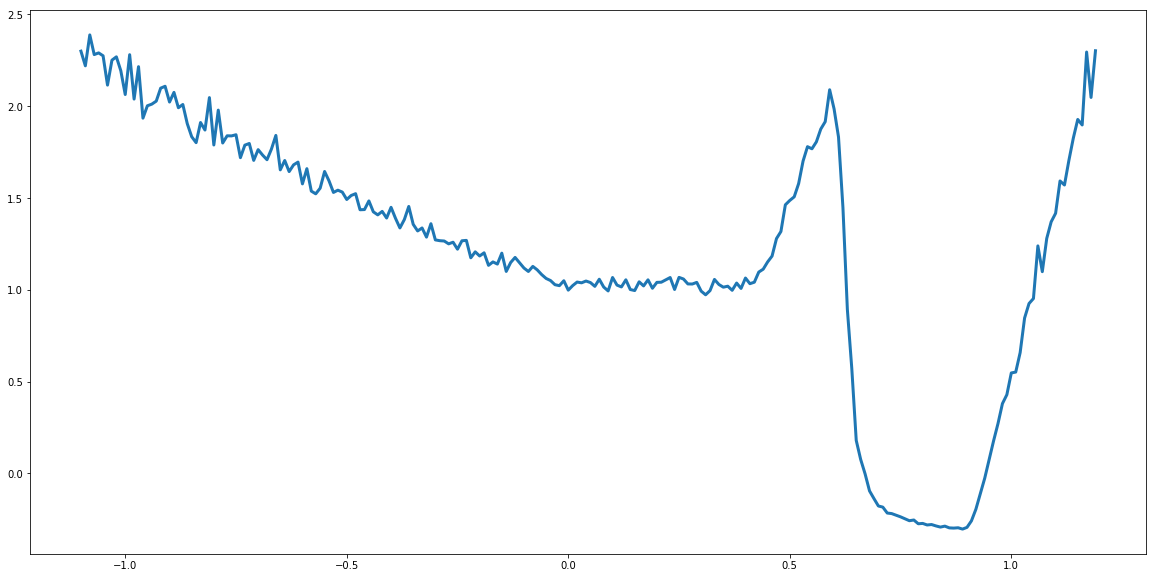

In [385]:
n_passes = 30
dropout_rate = 0.4

n_samples = 100
x, y, w = generate_samples_heteroscedastic(n_samples, variance=0.03)
#x, y = generate_nonlinear()

if 0 in x:
    x = np.delete(x, 0)
    y = np.delete(y, 0)

x = x.reshape([-1, 1])
y = y.reshape([-1, 1])


x_data = tf.placeholder(tf.float32, [None, 1], name="x_data")
y_data = tf.placeholder(tf.float32, [None, 1], name="y_data")

def combined_network(x):
    with tf.device("/gpu:0"):
        training= True
            
        fc1 = tf.layers.dense(inputs=x, units=50, activation=tf.nn.relu)
        fc1 = tf.layers.dropout(fc1, dropout_rate, training=True)
        
        fc2 = tf.layers.dense(inputs=fc1, units=50, activation=tf.nn.relu)
        fc2 = tf.layers.dropout(fc2, dropout_rate, training=True)
        

        # Output layers has predictive mean and variance sigma^2
        output_layer = tf.layers.dense(fc2, units=2)
        predictions = tf.reshape(output_layer, [-1, 2])
        
        return predictions

predictions = combined_network(x_data)
y_hat = tf.reshape(predictions[:, 0], [-1, 1]) 
s = tf.reshape(predictions[:, 1], [-1, 1])
#sigma2 = tf.reshape(predictions[:, 1], [-1, 1]) 
#sigma2 = tf.square(sigma2)

learning_rate = 0.0001
display_step = 2000
training_epochs = 40000

#optimizer = tf.train.AdamOptimizer(learning_rate)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)

# Loss for combined aleatoric and epistemic uncertainty
# TODO: Add weight decay
#s = tf.log(sigma2)
combined_loss = tf.reduce_sum(0.5 * tf.exp(-1 * s) * tf.square(tf.abs(y_data - y_hat)) + 0.5 * s, axis=1)
#mbined_loss = (tf.nn.l2_loss(y_data - y_hat) / 2*sigma2) + tf.log(sigma2)

train = optimizer.minimize(combined_loss) 

init = tf.global_variables_initializer()                                  
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)


for epoch in range(training_epochs):
    sess.run(train, feed_dict={x_data: x, y_data: y})

    if (epoch % display_step == 0):
        print("Epoch {}".format(epoch))
        loss = sess.run(combined_loss, feed_dict={x_data: x,
                                                  y_data: y})
        print("Loss: {}".format(loss))
        print("================")

print("Training done")


n_passes = 100
pred_x = np.arange(-1.1, 1.2, 0.01)
pred_x_multipass = np.array([[e] * n_passes for e in pred_x]).reshape([-1, 1])
pred_x = pred_x.reshape([-1, 1])
pred_y = sess.run(y_hat, feed_dict={x_data: pred_x_multipass})
#sigma2_multipass = sess.run(sigma2, feed_dict={x_data: pred_x_multipass})
pred_y = pred_y.reshape(-1, n_passes)
#sigma2_multipass = sigma2_multipass.reshape(-1, n_passes)
#sigma2_mean = sigma2_multipass.reshape(-1, n_passes).mean(axis=1).reshape(-1, 1)

# pred_y has now multipass shape
pred_y_mean = pred_y.mean(axis=1).reshape([-1, 1])
pred_y_mean_squared = np.square(pred_y).mean(axis=1).reshape([-1, 1])


pred_epistemic_var = pred_y.var(axis=1).reshape([-1, 1])
ic_var = pred_y.std(axis=1).reshape([-1, 1])
#pred_var = sess.run(sigma2, feed_dict={x_data: pred_x})

#combined_uncertainty = pred_y_mean_squared - np.square(pred_y_mean) + sigma2_mean

plt.figure(figsize=(20,10))
plt.plot(pred_x, pred_y_mean, label="Predictive Mean", linewidth=3)
plt.plot(pred_x, pred_var, label="Aleatoric Variance")
plt.plot(pred_x, pred_epistemic_var, label="Epistemic Variance")
#plt.plot(pred_x, combined_uncertainty, label="Combined Uncertainty")
plt.scatter(x, y, label="training samples", alpha=0.1)
plt.legend()

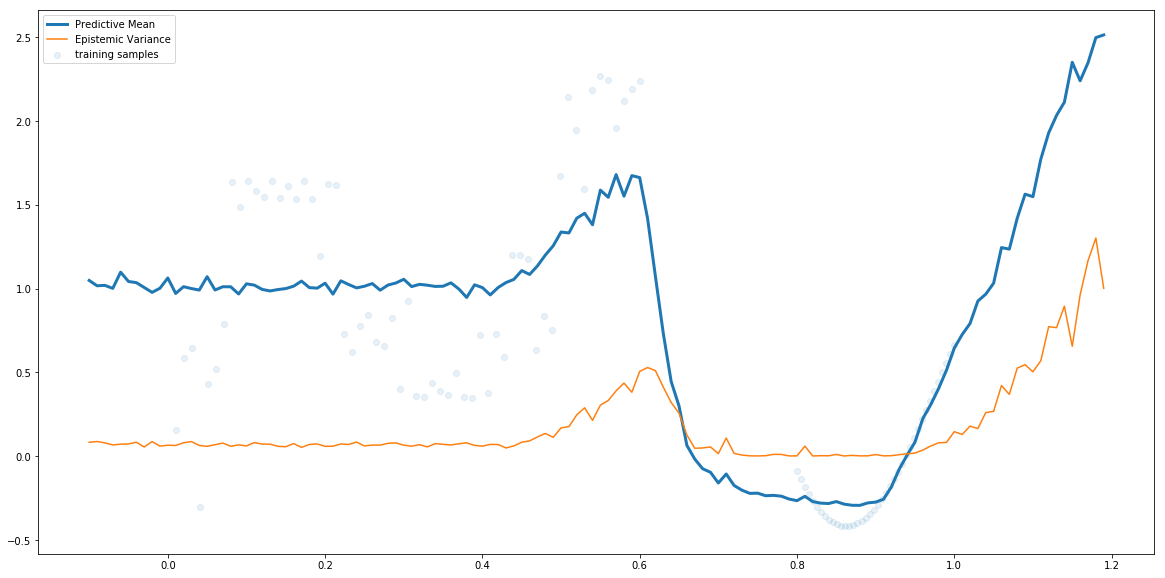

In [380]:
n_passes = 100
pred_x = np.arange(-0.1, 1.2, 0.01)
pred_x_multipass = np.array([[e] * n_passes for e in pred_x]).reshape([-1, 1])
pred_x = pred_x.reshape([-1, 1])
pred_y = sess.run(y_hat, feed_dict={x_data: pred_x_multipass})
#sigma2_multipass = sess.run(sigma2, feed_dict={x_data: pred_x_multipass})
pred_y = pred_y.reshape(-1, n_passes)
#sigma2_multipass = sigma2_multipass.reshape(-1, n_passes)
#sigma2_mean = sigma2_multipass.reshape(-1, n_passes).mean(axis=1).reshape(-1, 1)

# pred_y has now multipass shape
pred_y_mean = pred_y.mean(axis=1).reshape([-1, 1])
pred_y_mean_squared = np.square(pred_y).mean(axis=1).reshape([-1, 1])


pred_epistemic_var = pred_y.var(axis=1).reshape([-1, 1])
ic_var = pred_y.std(axis=1).reshape([-1, 1])
#pred_var = sess.run(sigma2, feed_dict={x_data: pred_x})

#combined_uncertainty = pred_y_mean_squared - np.square(pred_y_mean) + sigma2_mean

plt.figure(figsize=(20,10))
plt.plot(pred_x, pred_y_mean, label="Predictive Mean", linewidth=3)
#plt.plot(pred_x, pred_var, label="Aleatoric Variance")
plt.plot(pred_x, prekkkkd_epistemic_var, label="Epistemic Variance")
#plt.plot(pred_x, combined_uncertainty, label="Combined Uncertainty")
plt.scatter(x, y, label="training samples", alpha=0.1)
plt.legend()

In [381]:
s_multi = sess.run(s, feed_dict={x_data: pred_x_multipass})

(13000, 1)

(array([  6.,  21.,  19.,  23.,  15.,   8.,   5.,   1.,   1.,   1.]),
 array([ 0.39016899,  0.7668069 ,  1.1434448 ,  1.5200827 ,  1.89672061,
         2.27335851,  2.64999641,  3.02663431,  3.40327222,  3.77991012,
         4.15654802]),
 <a list of 10 Patch objects>)

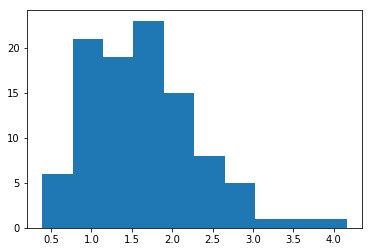

In [372]:
plt.hist(pred_y.reshape(-1))

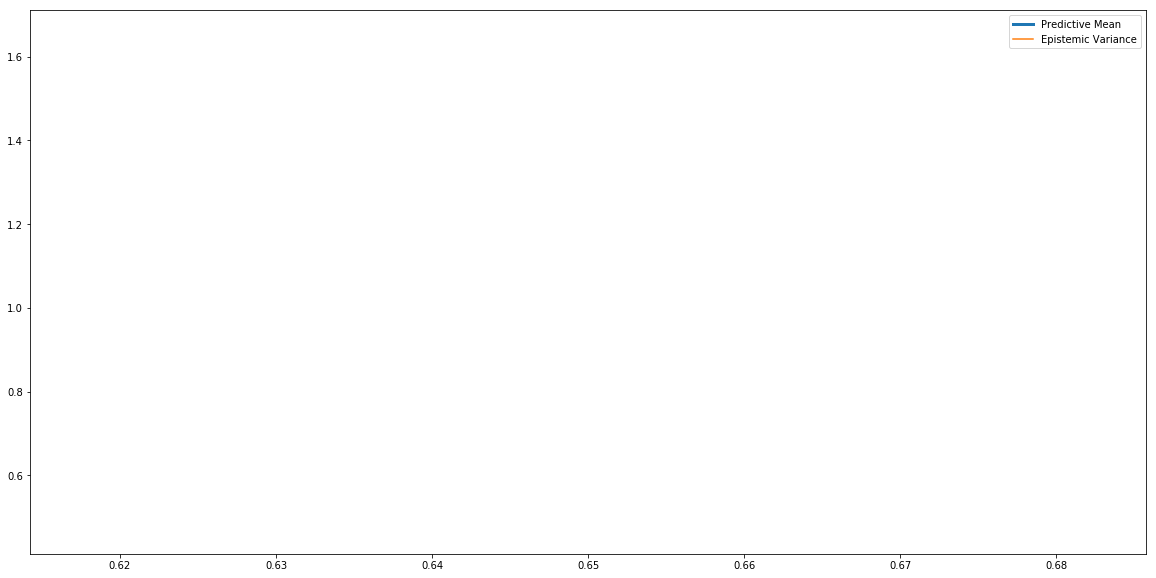

In [368]:
n_passes = 100
#pred_x = np.arange(0.74, 0.75, 0.01)
pred_x = np.array([0.65])
pred_x_multipass = np.array([[e] * n_passes for e in pred_x]).reshape([-1, 1])
pred_x = pred_x.reshape([-1, 1])
pred_y = sess.run(y_hat, feed_dict={x_data: pred_x_multipass})
pred_y = pred_y.reshape(-1, n_passes)

# pred_y has now multipass shape
pred_y_mean = pred_y.mean(axis=1).reshape([-1, 1])
pred_y_mean_squared = np.square(pred_y).mean(axis=1).reshape([-1, 1])


pred_epistemic_var = pred_y.var(axis=1).reshape([-1, 1])
ic_var = pred_y.std(axis=1).reshape([-1, 1])

plt.figure(figsize=(20,10))
plt.plot(pred_x, pred_y_mean, label="Predictive Mean", linewidth=3)
#plt.plot(pred_x, pred_var, label="Aleatoric Variance")
plt.plot(pred_x, pred_epistemic_var, label="Epistemic Variance")
#plt.scatter(x, y, label="training samples", alpha=0.8)
plt.legend()

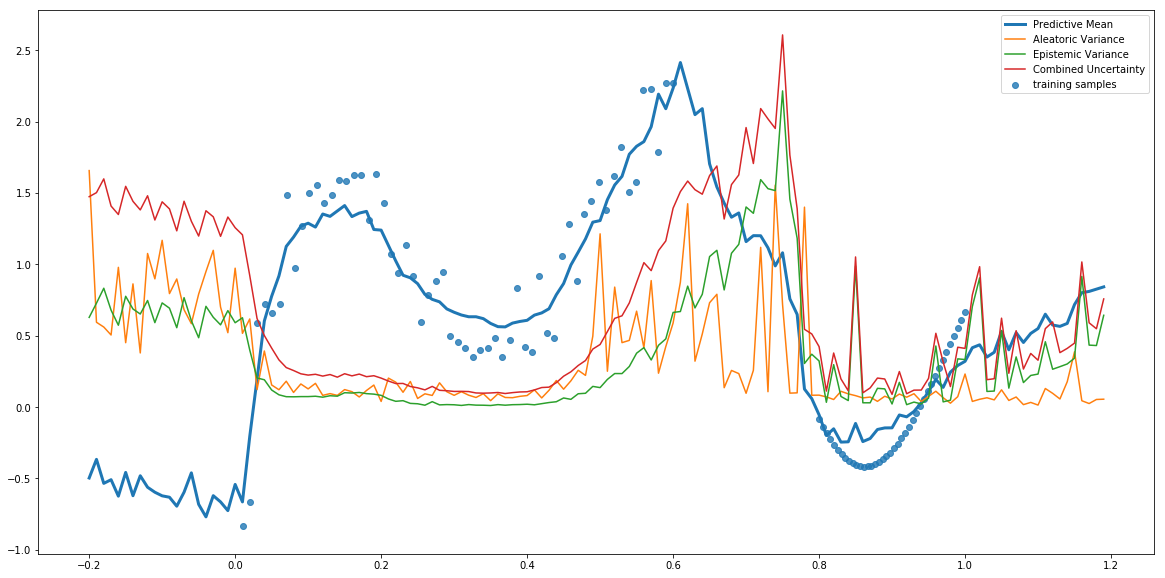

In [344]:
n_passes = 100
pred_x = np.arange(-0.2, 1.2, 0.01)
pred_x_multipass = np.array([[e] * n_passes for e in pred_x]).reshape([-1, 1])
pred_x = pred_x.reshape([-1, 1])
pred_y = sess.run(y_hat, feed_dict={x_data: pred_x_multipass})
sigma2_multipass = sess.run(sigma2, feed_dict={x_data: pred_x_multipass})
pred_y = pred_y.reshape(-1, n_passes)lk
sigma2_multipass = sigma2_multipass.reshape(-1, n_passes)
sigma2_mean = sigma2_multipass.reshape(-1, n_passes).mean(axis=1).reshape(-1, 1)

# pred_y has now multipass shape
pred_y_mean = pred_y.mean(axis=1).reshape([-1, 1])
pred_y_mean_squared = np.square(pred_y).mean(axis=1).reshape([-1, 1])


pred_epistemic_var = pred_y.var(axis=1).reshape([-1, 1])
ic_var = pred_y.std(axis=1).reshape([-1, 1])
pred_var = sess.run(sigma2, feed_dict={x_data: pred_x})

combined_uncertainty = pred_y_mean_squared - np.square(pred_y_mean) + sigma2_mean

plt.figure(figsize=(20,10))
plt.plot(pred_x, pred_y_mean, label="Predictive Mean", linewidth=3)ö
plt.plot(pred_x, pred_var, label="Aleatoric Variance")
plt.plot(pred_x, pred_epistemic_var, label="Epistemic Variance")
plt.plot(pred_x, combined_uncertainty, label="Combined Uncertainty")
plt.scatter(x, y, label="training samples", alpha=0.8)
plt.legend()